In [41]:
from __future__ import print_function
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
import math

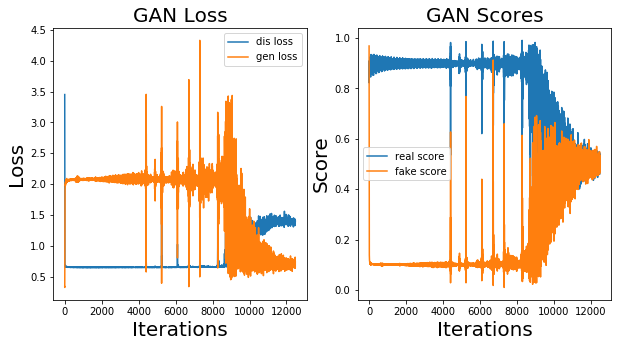

In [61]:
ntest = 6
score_real = np.load('./result_scat%s/scat_score_real_%s.npy'%(ntest,ntest))
score_fake = np.load('./result_scat%s/scat_score_fake_%s.npy'%(ntest,ntest))
loss_gen = np.load('./result_scat%s/scat_loss_gen_%s.npy'%(ntest,ntest))
loss_dis = np.load('./result_scat%s/scat_loss_dis_%s.npy'%(ntest,ntest))
# print(len(score_real))
# print(len(score_fake))
# print(len(loss_gen))
# print(len(loss_dis))
fig = plt.figure(figsize = (10,5))
font = {'size':20}
nsteps = len(loss_gen)

ax2 = fig.add_subplot(121)
ax2.plot(np.arange(nsteps), np.array(loss_dis), label='dis loss')
ax2.plot(np.arange(nsteps), np.array(loss_gen), label='gen loss')
ax2.set_title('GAN Loss',font)
ax2.set_xlabel('Iterations',font)
ax2.set_ylabel('Loss',font)
ax2.legend()

nsteps = len(score_real)
ax3 = fig.add_subplot(122)
ax3.plot(np.arange(nsteps), np.array(score_real), label='real score')
ax3.plot(np.arange(nsteps), np.array(score_fake), label='fake score')
ax3.set_title('GAN Scores',font)
ax3.set_xlabel('Iterations',font)
ax3.set_ylabel('Score',font)
ax3.legend()
# plt.savefig('scat-GAN-result')

In [62]:
score_fake[-1]

0.48160386085510254

In [63]:
class scattering(torch.nn.Module):
    def __init__(self, g_real_hat, g_imag_hat, g2_real_hat, g2_imag_hat, l2, layer2, nbatch, n):
        # g_real_hat: real part of wavelets in frequency
        # g_imag_hat: imagery part of wavelets in frequency
        # nbatch: length of batch
        # n: signal length
        super(scattering, self).__init__()
        self.g_real_hat = g_real_hat.unsqueeze(0) # shape 1 * nwave * n
        self.g_imag_hat = g_imag_hat.unsqueeze(0)
        self.g2_real_hat = g2_real_hat.unsqueeze(0) # shape 1 * nwave * n
        self.g2_imag_hat = g2_imag_hat.unsqueeze(0)
        self.nbatch = nbatch
        self.nwave = g_real_hat.shape[0]
        self.x_imag = torch.zeros(self.nbatch, 1, n, 1) # imagery part of x is zero
        self.x2_imag = torch.zeros(self.nbatch, self.nwave, n, 1)
        if torch.cuda.is_available():
            self.x_imag = self.x_imag.cuda()
    def forward(self, x_real):
        # x_real: n_batch * 1 * n
        self.x_real = x_real.unsqueeze(3)
        self.x = torch.cat((self.x_real, self.x_imag), 3) # n_batch * 1 * n * 2

        # convolution in frequency
        x_hat = torch.fft(self.x, 1) # fft
        y_real_hat = x_hat[:,:,:,0] * self.g_real_hat - x_hat[:,:,:,1] * self.g_imag_hat # multiply in freq n_batch * nwave * n
        y_imag_hat = x_hat[:,:,:,0] * self.g_imag_hat + x_hat[:,:,:,1] * self.g_real_hat # multiply in freq
        y = torch.ifft(torch.cat((y_real_hat.unsqueeze(3), y_imag_hat.unsqueeze(3)), 3), 1) # ifft, n_batch * nwave * n * 2
        temp = torch.sqrt(y[:,:,:,0]**2 + y[:,:,:,1]**2) # nonlinear operator: modulus, n_batch * nwave * n

        # scattering
        s = torch.sum(temp, 2)

        # add l2 norm
        if l2:
            s = torch.cat((s, torch.sum(temp**2, 2)), 1)
        # add second layer
        if layer2:
            temp = temp.unsqueeze(3)
            temp2 = torch.zeros(self.nbatch, nwave, n)
            x2 = torch.cat((temp, self.x2_imag), 3) # n_batch * nwave * n * 2
            x2_hat = torch.fft(x2, 1)
            for i in range(self.nwave):
                y2_real_hat = x2_hat[:,i,:,0] * self.g2_real_hat[:,i,:] - x2_hat[:,i,:,1] * self.g2_imag_hat[:,i,:] # nbatch * n
                y2_imag_hat = x2_hat[:,i,:,0] * self.g2_imag_hat[:,i,:] + x2_hat[:,i,:,1] * self.g2_real_hat[:,i,:]
                y2 = torch.ifft(torch.cat((y2_real_hat.unsqueeze(2), y2_imag_hat.unsqueeze(2)), 2), 1) # nbatch * n * 2
            #    print(temp2.shape)
            #    print(y2.shape)
                temp2[:, i, :] = torch.sqrt(y2[:,:,0]**2 + y2[:,:,1]**2) # nonlinear operator: modulus, n_batch * nwave * n
            s = torch.cat((s, torch.sum(temp2, 2)), 1)
            if l2:
                s = torch.cat((s, torch.sum(temp2**2, 2)), 1)
        return s.unsqueeze(1) # nbatch * 1 *  nf


class Discriminator(torch.nn.Module):

    def __init__(self, batch_disc, ns, n):
        super(Discriminator, self).__init__()
        self.ns = ns # number of scattering coefficients
        self.n = n # signal length
        self.in_features = 1024
        self.out_features = 128
        self.kernel_dims = 16
        self.mean = False

        self.l0 = nn.Linear(self.ns, self.n)

        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1, out_channels=128, kernel_size=16,
                stride=4, padding=6, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=128, out_channels=256, kernel_size=16,
                stride=4, padding=6, bias=False
            ),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.l1 = nn.Sequential(
            nn.Linear(256*256, self.in_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

#        self.T = nn.Parameter(torch.Tensor(self.in_features, self.out_features, self.kernel_dims))
#        init.normal_(self.T, 0, 1)
        self.batch_disc = batch_disc
        if self.batch_disc:
            self.T = nn.Parameter(torch.randn(self.in_features, self.out_features, self.kernel_dims)*0.1, requires_grad = True)
            self.out = nn.Sequential(
                nn.Linear(self.in_features + self.out_features, 1),
                nn.Sigmoid(),
            )
        else:
            self.out = nn.Sequential(
                nn.Linear(self.in_features, 1),
                nn.Sigmoid(),
            )

    def forward(self, x, pr = False):
        x = self.l0(x)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 256*16*16)
        x = self.l1(x)
        if self.batch_disc:
            # minibatch discrimination after third layer(fully connected)
            matrices = x.mm(self.T.view(self.in_features, -1))
            matrices = matrices.view(-1, self.out_features, self.kernel_dims)

            M = matrices.unsqueeze(0)  # 1xNxBxC
            M_T = M.permute(1, 0, 2, 3)  # Nx1xBxC
            norm = torch.abs(M - M_T).sum(3)  # NxNxB
            expnorm = torch.exp(-norm)
            o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance
            if self.mean:
                o_b /= x.size(0) - 1

            x = torch.cat([x, o_b], 1) # concatenate l1 feature and cross sample feature
        if pr:
            print('value before sigmoid: ',torch.mean(x))
        x = self.out(x)
        if pr:
            print('value after sigmoid: ', torch.mean(x))
        return x
    
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.l1 = nn.Sequential(
            nn.Linear(100, 1024),
            nn.Tanh()
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 256*256),
            nn.Tanh()
        )

        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=256, out_channels=128, kernel_size=8,
                stride=4, padding=2, bias=False
            ),
            nn.BatchNorm1d(128),
            nn.Tanh()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=128, out_channels=1, kernel_size=8,
                stride=4, padding=2, bias=False
            )
        )
        self.out = torch.nn.Sigmoid()

    def forward(self, x):
        # Project and reshape
        x = self.l1(x)
        x = self.l2(x)
        x = x.view(x.shape[0], 256, 16*16)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        # Apply Tanh
        return self.out(x)

In [64]:
def determine_sigma(epsilon):
    sigma = np.sqrt(- 2 * np.log(epsilon)) / math.pi
    return sigma

def determine_J(N, Q, sigma, *alpha):
    if len(alpha) == 0:
        alpha = 3
    J = np.log2(N) - np.log2(alpha) - np.log2(sigma) - 1
    int_J = max(np.floor(J), 1);
    frac_J = (1/Q) * np.around((J - int_J) * Q);
    J = int_J + frac_J;
    return J

def gabor_wave_1d(n, s, xi):
    # generate one 1D gabor wavelet 
    x = np.arange(n) - np.floor(n/2)
    chi = np.zeros(n)
    chi[0:s] = 1/s
#     chi[0:s] = 1

    o = np.exp(1j * xi * x)

    psi = np.multiply(chi, o)

    psi_hat = np.fft.fft(psi)
    return psi, psi_hat


def gabor_wave_family_1d(n, s, xi):
    # generate a family of 1D gabor wavelets with specified scales and rotations in space
    ns = s.shape[0]
    nxi = xi.shape[0]

    psi = np.zeros((n, ns, nxi),dtype=complex)
    psi_hat = np.zeros((n, ns, nxi),dtype=complex)
    for i in range(ns):
        for k in range(nxi):
                psi[:, i, k], psi_hat[:, i, k] = gabor_wave_1d(n, int(s[i]), xi[k])
    return psi, psi_hat


In [65]:
x_data = np.load('/Users/kejiqing/Desktop/research/synthesis/python/data/x4_4096_data.npy')
ndata = x_data.shape[0]
x_data = torch.from_numpy(np.reshape(x_data,[-1,1,2**12])).float()
print('Data loaded!')

Data loaded!


In [66]:
# define wavelets
n = 2**12
pi = math.pi
epsilon = 1e-4
sigma = determine_sigma(epsilon)
Q = 2
alpha = 2
J = determine_J(n, Q, sigma, alpha)
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
#s = np.array([1,2,4,8,10,16,31,63,129,257,513])
xi = 2 * pi * np.random.choice(n,1) / n
xi2 = 2 * pi * np.random.choice(n,1) / n
np.save('xi', xi)
np.save('xi2', xi2)

g, g_hat = gabor_wave_family_1d(n,s,xi)
g = np.reshape(g, (g.shape[0], -1)) # n * nwave
nwave = g.shape[1]
g_hat = np.swapaxes(np.reshape(g_hat, (g_hat.shape[0], -1)), 0, 1) # nwave * n
g_real_hat = torch.from_numpy(np.real(g_hat)).float()
g_imag_hat = torch.from_numpy(np.imag(g_hat)).float()

c = 4
s2 = s * c
g2, g2_hat = gabor_wave_family_1d(n,s2,xi2)
g2 = np.reshape(g2, (g2.shape[0], -1)) # n * nwave
g2_hat = np.swapaxes(np.reshape(g2_hat, (g2_hat.shape[0], -1)), 0, 1) # nwave * n
g2_real_hat = torch.from_numpy(np.real(g2_hat)).float()
g2_imag_hat = torch.from_numpy(np.imag(g2_hat)).float()

if torch.cuda.is_available():
    g_real_hat = g_real_hat.cuda()
    g_imag_hat = g_imag_hat.cuda()
    g2_real_hat = g2_real_hat.cuda()
    g2_imag_hat = g2_imag_hat.cuda()
print('wavelets defined')

# Number of epochs
n = 2**12
lambda_true = 0.025
num_epochs = 200
pretrain_epochs = 10
batch_size = 64
nbatch = ndata // batch_size
num_test_samples = 16
batch_disc = True # do minibatch discrimination
l2 = False
layer2 = True

wavelets defined


In [79]:
g = Generator()
g.load_state_dict(torch.load('./result_scat%s/scat_GAN_GEN_test%s'%(ntest, ntest), map_location=lambda storage, loc: storage))
nf = nwave
if l2:
    nf = 2 * nf
if layer2:
    nf = 2 * nf
d = Discriminator(batch_disc, nf, n)
d.load_state_dict(torch.load('./result_scat%s/scat_GAN_DISC_test%s'%(ntest,ntest), map_location=lambda storage, loc: storage))

s = scattering(g_real_hat, g_imag_hat, g2_real_hat, g2_imag_hat, l2, layer2, batch_size, n)


36


In [84]:
nz = 100
epsilon = torch.randn(batch_size,nz)
epsilon = Variable(epsilon, requires_grad=False)
output = g(epsilon)
score = d(s(output))

torch.Size([64, 1, 36])


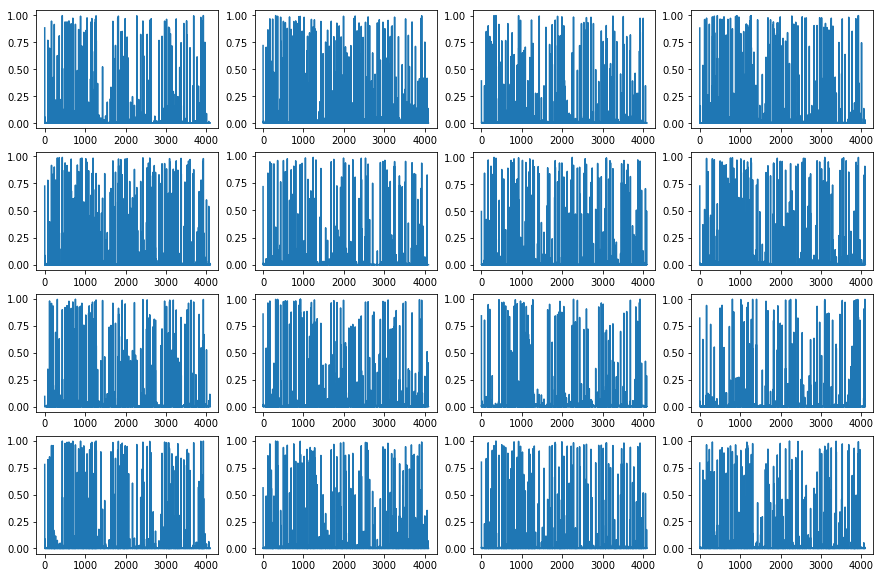

In [85]:
fake_signal = output.squeeze(1).data.cpu().numpy()
# np.save('fake_signal', fake_signal)
# visualizetion of generated signal
fig = plt.figure(figsize = (15,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(fake_signal[i,:])
# plt.savefig('fake-signal')

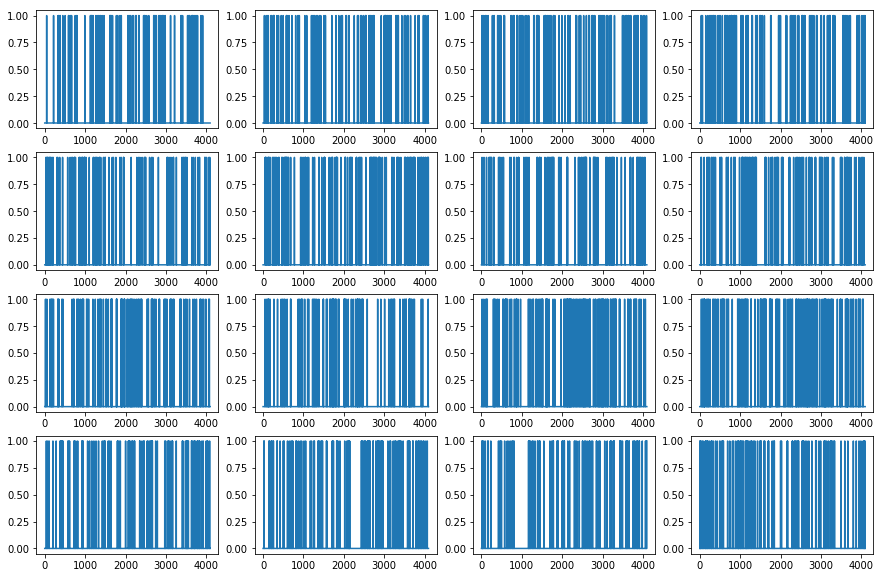

In [87]:
x = np.load('/Users/kejiqing/Desktop/research/synthesis/python/data/x4_4096_data.npy')
# samples from original signal
fig = plt.figure(figsize = (15,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(x[i,:])
# plt.savefig('real-signal')

In [88]:
sx_fake = s(output)
ind = range(batch_size)
real_signal = torch.from_numpy(x[ind, :]).float().unsqueeze(1)
sx_real = s(real_signal)

In [100]:
fake_score = d(sx_fake)
real_score = d(sx_real)

In [102]:
real_score

tensor([[0.8172],
        [0.7885],
        [0.7370],
        [0.7374],
        [0.8375],
        [0.8557],
        [0.7701],
        [0.7301],
        [0.8210],
        [0.7902],
        [0.8584],
        [0.8578],
        [0.7188],
        [0.7850],
        [0.7760],
        [0.7270],
        [0.7838],
        [0.8564],
        [0.7746],
        [0.6962],
        [0.6946],
        [0.7950],
        [0.7358],
        [0.8329],
        [0.7530],
        [0.7410],
        [0.7791],
        [0.7883],
        [0.7492],
        [0.7554],
        [0.7882],
        [0.8289],
        [0.7342],
        [0.7469],
        [0.8476],
        [0.7422],
        [0.7132],
        [0.7715],
        [0.8746],
        [0.7374],
        [0.7700],
        [0.7391],
        [0.7435],
        [0.7771],
        [0.8179],
        [0.7215],
        [0.8231],
        [0.7964],
        [0.8094],
        [0.7296],
        [0.7193],
        [0.8218],
        [0.7785],
        [0.7208],
        [0.8519],
        [0

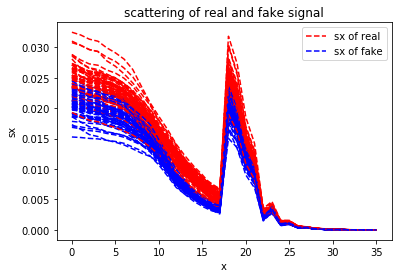

In [109]:
#ind = np.arange(18) * 2
ind = np.arange(55)
fig = plt.figure()
t = np.arange(nf)
for i in range(64):
    y1 = sx_real.squeeze(1).data.cpu().numpy()[i,:]/2**12
    y2 = sx_fake.squeeze(1).data.cpu().numpy()[i,:]/2**12
    if i == 0:
        plt.plot(t, y1, c = 'red', linestyle = 'dashed', label = 'sx of real')
        plt.plot(t, y2, c = 'blue', linestyle = 'dashed', label = 'sx of fake')
    else:
        plt.plot(t, y1, linestyle = 'dashed', c = 'red')
        plt.plot(t, y2, linestyle = 'dashed', c = 'blue')
plt.xlabel('x')
plt.ylabel('sx')
plt.title('scattering of real and fake signal')
plt.legend()
plt.show()

# y3 = torch.mean(sx_real, 0).squeeze().data.cpu().numpy()/2**12
# y4 = torch.mean(sx_fake, 0).squeeze().data.cpu().numpy()/2**12





# fig.savefig('scattering-coeff')

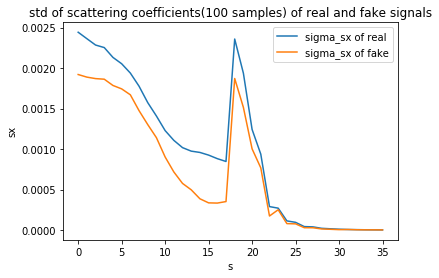

In [93]:
v1 = np.std(sx_real.squeeze().data.cpu().numpy()/2**12, axis = 0)
v2 = np.std(sx_fake.squeeze().data.cpu().numpy()/2**12, axis = 0)
fig = plt.figure()
plt.plot(t,v1, label = 'sigma_sx of real')
plt.plot(t,v2, label = 'sigma_sx of fake')
plt.title('std of scattering coefficients(100 samples) of real and fake signals')
plt.xlabel('s')
plt.ylabel('sx')
plt.legend()
plt.show()

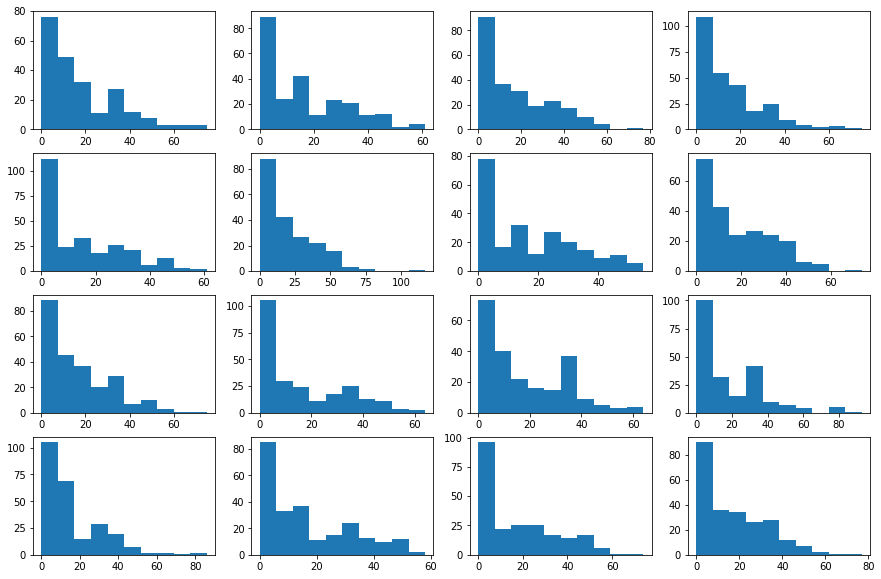

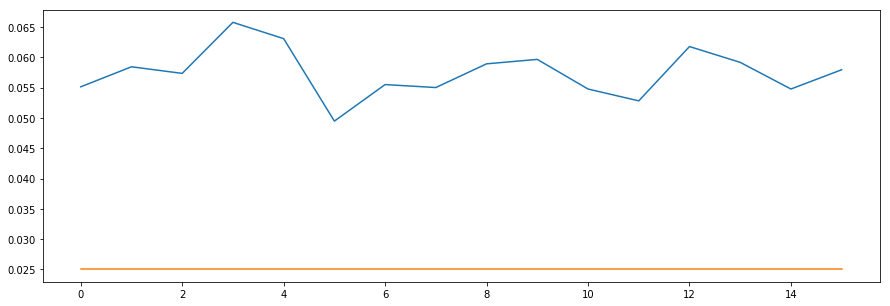

In [95]:
fig = plt.figure(figsize = (15,10))
lambda_hat = np.array([]) 
ind_delta_all = np.array([])
for i in range(16):
    ind = np.append([0], np.where(fake_signal[i,:] > 0.01))
    ind_delta = np.diff(ind).squeeze()
    ind_delta_all = np.append(ind_delta, ind_delta)
    lambda_hat = np.append(lambda_hat, 1/np.mean(ind_delta))
    plt.subplot(4,4,i+1)
    plt.hist(ind_delta)
fig1 = plt.figure(figsize = (15,5))
t = np.arange(0, 16, 1)
plt.plot(t, lambda_hat, t, np.ones(16)*0.025)

(array([180.,  72.,  68.,  52.,  56.,  24.,  14.,   4.,   2.,   2.]),
 array([ 0. ,  7.7, 15.4, 23.1, 30.8, 38.5, 46.2, 53.9, 61.6, 69.3, 77. ]),
 <a list of 10 Patch objects>)

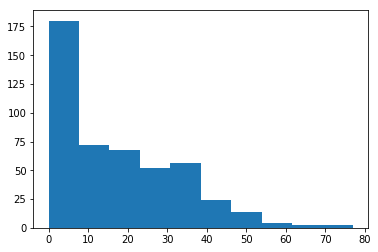

In [96]:
plt.hist(ind_delta_all)

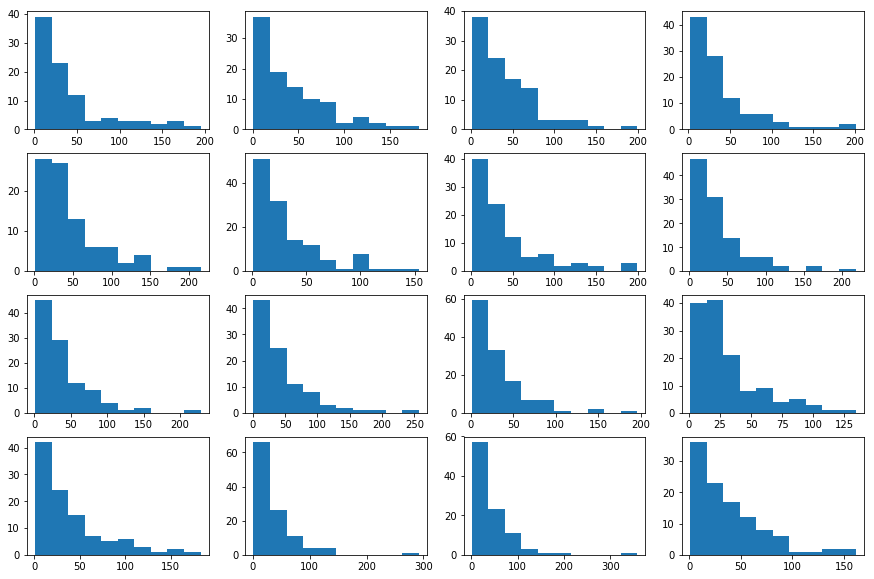

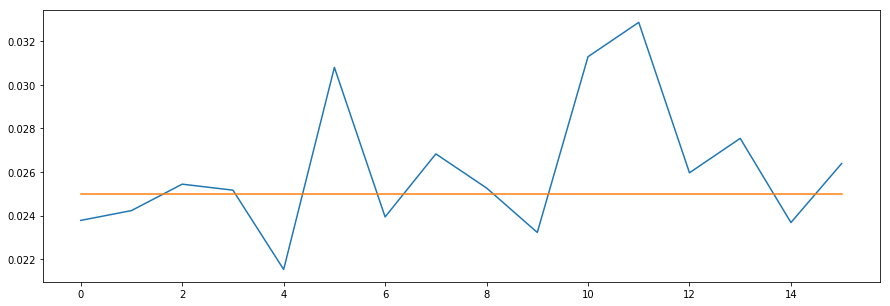

In [27]:
fig = plt.figure(figsize = (15,10))
lambda_hat = np.array([])   
for i in range(16):
    ind = np.append([0], np.where(x[i,:] > 0.1))
    ind_delta = np.diff(ind).squeeze()
    ind_delta_all = np.append(ind_delta, ind_delta)
    lambda_hat = np.append(lambda_hat, 1/np.mean(ind_delta))
    plt.subplot(4,4,i+1)
    plt.hist(ind_delta)
fig1 = plt.figure(figsize = (15,5))
t = np.arange(0, 16, 1)
plt.plot(t, lambda_hat, t, np.ones(16)*0.025)

In [28]:
sx_real_ave = np.mean(sx_real.squeeze(1).data.cpu().numpy(), 0)
sx_fake_ave = np.mean(sx_fake.squeeze(1).data.cpu().numpy(), 0)

In [29]:
np.sum((sx_real_ave - sx_fake_ave)**2/2**24)

0.04966380510108648